<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/aprendizaje_reforzado/q_aprendizaje_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación de taxi auto-conducido con Aprendizaje Reforzado

**Objetivo:** Demostrar en un entorno simplificado, cómo se pueden utilizar las técnicas de Aprendizaje Reforzado para desarrollar un enfoque eficiente abordar el problema.

## Introducción

En este *notebook* se simula el trabajo de un Taxi Inteligente, el cual consiste en recoger al pasajero en un lugar y dejarlo en otro. Estas son algunos de los comportamientos deseados por el taxi:

- Dejar al pasajero en el lugar correcto
- Ahorrar tiempo al pasajero tardando lo mínimo posible en dejarle
- Cuidar la seguridad del pasajero y las normas de tráfico

Hay diferentes aspectos que hay que considerar mientras se modela una solución de aprendizaje reforzado para este problema:
- recompensas
- estados
- acciones

#### 1. Recompensas

Dado que el agente (el conductor imaginario) está motivado por la recompensa y va a aprender a controlar el taxi mediante experiencias de prueba de entorno, tenemos que decidir las recompensas y/o penalizaciones y su magnitud en consecuencia.

Algunos puntos a tener en cuenta:

- El agente debe recibir una alta recompensa positiva por una entrega exitosa porque este comportamiento es muy deseado
- El agente debe ser penalizado si intenta dejar a un pasajero en lugares equivocados
- El agente debería recibir una ligera recompensa negativa por no llegar al destino después de cada paso de tiempo. "Ligeramente" negativo porque preferimos que el agente llegue tarde en lugar de hacer movimientos erróneos tratando de llegar al destino lo más rápido posible.

#### 2. Espacio de estados

En el aprendizaje por refuerzo, el agente se encuentra con un estado, y entonces toma una acción de acuerdo con el estado en el que se encuentra.

El espacio de estados es el conjunto de todas las situaciones posibles en las que puede encontrarse el taxi. El estado debe contener información útil que el agente necesita para realizar la acción correcta.

Supongamos que se cuenta un área de entrenamiento para nuestro taxi en el que le estamos enseñando a transportar personas en un estacionamiento sobre cuatro  diferentes lugares (R, G, Y, B):

<img src='https://storage.googleapis.com/lds-media/images/Reinforcement_Learning_Taxi_Env.width-1200.png'>

Supongamos que nuestro taxi es el único vehículo en este estacionamiento. Podemos dividir el estacionamiento en una cuadrícula de 5x5, lo que nos brinda 25 posibles ubicaciones para el taxi. Estos 25 lugares son una parte de nuestro espacio de estados. Importante observar que el estado de ubicación actual de nuestro taxi es la coordenada `(3, 1)`.

Identificar también que hay cuatro ubicaciones en las que podemos recoger y dejar a un pasajero: R, G, Y, B o `[(0,0), (0,4), (4,0), (4,3)]` en coordenadas `(fila, columna)`. Nuestro pasajero ilustrado está en la ubicación Y y desea ir a la ubicación R.

Adicionalmente cuando contabilizamos un estado de pasajero adicional dentro del taxi, podemos tomar todas las combinaciones de ubicaciones de pasajeros y ubicaciones destino para llegar a un número total de estados para nuestro entorno de taxi. 

Al haber cuatro destinos y cinco ubicaciones de pasajeros, nuestro entorno de taxi tiene un total de $5x5x5x4=500$ estados posibles.

#### 3. Espacio de acción

El agente se encuentra en uno de los 500 estados y realiza una acción. La acción en nuestro caso puede ser moverse en una dirección o decidir recoger/dejar a un pasajero.

En otras palabras, tenemos seis acciones posibles:

1. Sur
2. Norte
3. Este
4. Oeste
5. Recoger al pasajero
6. Dejar al pasajero


El espacio de acción es el conjunto de todas las acciones que nuestro agente puede realizar en un estado dado.

Se debe notar en la ilustración de arriba que el taxi no puede realizar ciertas acciones en ciertos estados debido a las paredes. En el código del entorno, simplemente se proporciona una penalización de -1 por cada pared golpeada y el taxi no se moverá a ningún lado. Esto solo acumulará penalizaciones que harán que el taxi considere dar la vuelta en caso de topar con pared.

## Implementación con Python

OpenAI Gym tiene este entorno ya creado como parte de la libería.

Gym proporciona diferentes entornos de juego que se pueden utilizar y probar un agente. La biblioteca se encarga de la API para proporcionar toda la información que el agente requiera, como posibles acciones, puntuación y estado actual. Sin embargo, aún se tiene que implementar el algoritmo de aprendizaje para el agente.

Se utilizará el entorno Gym llamado 'Taxi-v3', del cual se extraen todos los detalles explicados anteriormente. Los objetivos, recompensas y acciones son todos iguales.

Se necesita instalar la librería gym primero y para ello se deben ejecutar las siguientes celdas:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
!pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Una vez instalado, podemos cargar el entorno del juego y renderizar lo que parece:

In [ ]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
env = gym.make('Taxi-v3')

In [ ]:
state = env.reset()
print(f"Initial state: {state}")

Initial state: 268


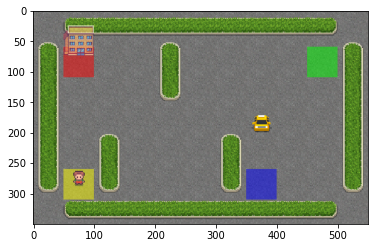

In [ ]:
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen);

La interfaz núcleo de la librería gym es `env`, que es la interfaz de entorno unificado. Se enlistan algunos métodos de `env` relevantes:

- `env.reset()`: reinicia el entorno y devuelve un estado inicial aleatorio
- `env.step(action)`: Desplaza al agente en una unidad de tiempo $t$ y además devuelve:

    * estado : Observaciones del entorno
    * recompensa : Si la acción es beneficiosa o si por el contrario se penaliza
    * hecho : Indica si hemos recogido y dejado con éxito a un pasajero
    * info : Información adicional como el rendimiento y la latencia con fines de depuración

- `env.render()`: Renderiza un fotograma del entorno (útil para efectos de visualización)

### Recompensa y penalización

Existen 4 ubicaciones (etiquetadas con letras diferentes), y el objetivo es recoger al pasajero en una ubicación y dejarlo en otra.
Se reciben 20 puntos por una entrega exitosa y se pierde 1 punto por cada movimiento que se toma. También hay una penalización de 10 puntos por acciones ilegales de recogida y entrega.

In [ ]:
env.reset()
env.render(mode='rgb_array')

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


Se cuenta entonces con un espacio de acción de tamaño 6 y un espacio de estados de tamaño 500. Para efectos de este ejercicio no se necesitará más información pues todo lo que se necesita es una forma de identificar un estado de manera única asignando un número único a cada estado posible, y el algoritmo aprenderá a elegir un número de acción del 0 al 5 donde:

- 0 = sur
- 1 = norte
- 2 = este
- 3 = oeste
- 4 = recoger
- 5 = dejar

Imporante recordar que los 500 estados corresponden a una codificación de la ubicación del taxi, la ubicación del pasajero y la ubicación de destino.

El aprendizaje por refuerzo aprenderá un mapeo de estados a la acción óptima para realizar en ese estado por exploración, es decir, el agente explora el entorno y realiza acciones en función de las recompensas definidas en el entorno.

La acción óptima para cada estado es la acción que tiene la mayor recompensa acumulada a largo plazo.

Es posible configurar el estado inicial de acuerdo a la ilustración del problema, codificar su estado y dárselo al entorno para que se renderice.
Se busca que el taxi se encuentre ubicado en la fila 3, columna 1, nuestro pasajero está en la ubicación 2 y nuestro destino es la ubicación 0, esto usando el método de codificación de estados propuesto por Taxi-v3 en su respectiva documentación: https://www.gymlibrary.dev/environments/toy_text/taxi/

State: 328


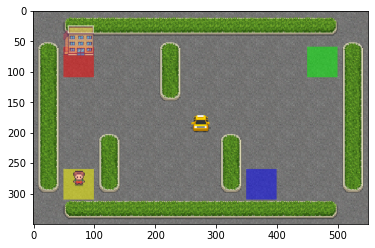

In [ ]:
state = env.encode(3, 1, 2, 0) # (fila del taxi, columna del taxi, índice del pasajero, índice del destino)
print("State:", state)

env.s = state
plt.imshow(env.render(mode='rgb_array'));

Se utilizan las coordenadas mencionadas previamente para generar el identificador correspondiente a un estado entre 0 y 499, que resulta ser 328 para el estado de ila ilustración.

Más adelante, se puede configurar el estado del entorno manualmente con `env.env.s` utilizando el mismo identificador codificado.

Se recomienda modificar el identificador coomo ejercicio para visualizar como el taxi, el pasajero y el destino se desplazan.

### Tabla de recompensas

Cuando se crea el entorno Taxi, también se crea una tabla de recompensas inicial llamada `P`. Se puede pensar en ella como una matriz que contiene el número de estados como filas y el número de acciones como columnas, es decir, una matriz de `estados x acciones`.

Dado que cada estado está en esta matriz, podemos ver los valores de recompensa predeterminados asignados al estado de la siguiente ilustración:

In [ ]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

Este diccionario tiene la estructura `{action: [(probability, nextstate, reward, done)]}`.

Algunas cosas a tener en cuenta:

El 0-5 corresponde a las acciones (sur, norte, este, oeste, recoger, dejar) que el taxi puede realizar en nuestro estado actual en la ilustración.
En este entorno, `probability` siempre es 1.0.
El `nextstate` es el estado en el que estaríamos si tomamos la acción en este índice del dict
Todas las acciones de movimiento tienen una recompensa de -1 y las acciones de recoger/dejar tienen una recompensa de -10 en este estado en particular. Si estamos en un estado donde el taxi tiene un pasajero y está encima del destino correcto, veríamos una recompensa de 20 en la acción de entrega (5)
`done` se utiliza para decirnos cuándo hemos dejado con éxito a un pasajero en el lugar correcto. Cada entrega exitosa es el final de un episodio.

Tenga en cuenta que si nuestro agente elige explorar la acción dos (2) en este estado, se dirigirá hacia el este contra una pared. El código fuente ha hecho que sea imposible mover el taxi a través de una pared, por lo que si el taxi elige esa acción, seguirá acumulando penalizaciones de -1, lo que afecta la recompensa a largo plazo

### Resolviendo el entorno sin Aprendizaje por Refuerzo

Veamos qué pasaría si tratamos de resolver el problema por fuerza bruta sin RL.

Dado que tenemos nuestra tabla `P` de recompensas predeterminadas en cada estado, podemos intentar que nuestro taxi navegue solo con eso.

Crearemos un ciclo infinito que se ejecuta hasta que un pasajero llega a un destino (un episodio ), o en otras palabras, cuando la recompensa recibida es 20. El `env.action_space.sample()` método selecciona automáticamente una acción aleatoria del conjunto de todas las acciones posibles.

Veamos qué pasa:

In [ ]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='rgb_array'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 200
Penalties incurred: 70


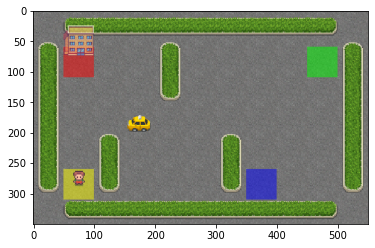

In [ ]:
#print(frames[0]['frame'])
plt.imshow(frames[0]['frame']);

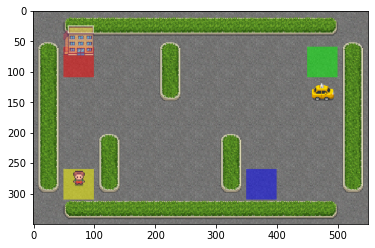

Timestep: 200
State: 188
Action: 4
Reward: -10


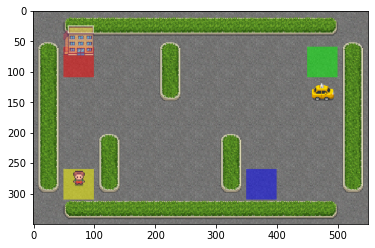

In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        #clear_output(wait=True)
        # print(frame['frame'])
        plt.imshow(frame['frame'])
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

In [ ]:
# num_steps = 50
# for s in range(50):
#     print(f"step: {s} out of {num_steps}")
#     action = env.action_space.sample()
#     obs, reward, done, info = env.step(action)
#     screen = env.render(mode='rgb_array')
#     time.sleep(0.5)
#     plt.imshow(screen);
#     ipythondisplay.clear_output(wait=True)
#     ipythondisplay.display(plt.gcf())

#     if done:
#         break
    
# ipythondisplay.clear_output(wait=True)
# env.close()

No es bueno. Nuestro agente toma miles de pasos de tiempo y hace muchas devoluciones incorrectas para llevar a un solo pasajero al destino correcto.

Esto se debe a que no estamos aprendiendo de la experiencia pasada. Podemos ejecutar esto una y otra vez, y nunca se optimizará. El agente no tiene memoria de qué acción fue la mejor para cada estado, que es exactamente lo que el aprendizaje por refuerzo hará por nosotros.

## Introduzca el aprendizaje por refuerzo

Vamos a utilizar un algoritmo RL simple llamado Q-learning que le dará algo de memoria a nuestro agente.

### Introducción a Q-learning

Esencialmente, Q-learning le permite al agente usar las recompensas del entorno para aprender, con el tiempo, la mejor acción a tomar en un estado dado.

En nuestro entorno Taxi, tenemos la tabla de recompensas `P`, de la que aprenderá el agente. Lo hace buscando recibir una recompensa por realizar una acción en el estado actual, luego actualiza un valor Q para recordar si esa acción fue beneficiosa.

Los valores almacenados en la tabla Q se denominan valores Q y se asignan a una combinación `(state, action)`.

Un valor Q para una combinación particular de estado y acción es representativo de la "calidad" de una acción tomada desde ese estado. Mejores valores Q implican mejores posibilidades de obtener mayores recompensas.

Por ejemplo, si el taxi se enfrenta a un estado que incluye un pasajero en su ubicación actual, es muy probable que el valor Q de `pickup` sea mayor en comparación con otras acciones, como `dropoff` o `north`.

Los valores Q se inicializan en un valor arbitrario y, a medida que el agente se expone al entorno y recibe diferentes recompensas al ejecutar diferentes acciones, los valores Q se actualizan mediante la ecuación:

$Q({\small state}, {\small action}) \leftarrow (1 - \alpha) Q({\small state}, {\small action}) + \alpha \Big({\small reward} + \gamma \max_{a} Q({\small next \ state}, {\small all \ actions})\Big)$

In [ ]:
import numpy as np

q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [ ]:
%%time
"""Entrenando al agente"""

import random
from IPython.display import clear_output

# Hiperparámetros
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# Graficar métricas
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explora el espacio de acción
        else:
            action = np.argmax(q_table[state]) # Explotar los valores aprendidos

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Entrenamiento terminado.\n")

Episode: 100000
Entrenamiento terminado.

CPU times: user 1min 26s, sys: 7.36 s, total: 1min 34s
Wall time: 1min 29s


In [ ]:
q_table[328]

array([ -2.41691171,  -2.27325184,  -2.41728223,  -2.36289527,
       -11.19098231, -11.14393613])

In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.9
Average penalties per episode: 0.0
